In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import glob
import h5py
import re
from scipy import stats
from scipy.stats import norm

In [2]:
np.__version__

'1.21.6'

In [3]:
directory = '//allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_plots/figure_4/all_cre_clustering_090923_select_k/'

# Regular expression to match the desired file names
pattern = r'cluster_meta_n_(\d+)_clusters\.h5'

# Function to extract the number from the file name
def extract_number(filename):
    match = re.search(pattern, filename)
    if match:
        return int(match.group(1))
    return -1

# Get a list of all files in the directory
all_files = os.listdir(directory)

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [5]:
filename = 'cluster_meta_n_14_clusters.h5'

In [6]:
file_path = os.path.join(directory, filename)
cluster_df = pd.read_hdf(file_path, key='df')

In [17]:
%%time
import visual_behavior.ophys.response_analysis.cell_metrics as cm 

data_type = 'filtered_events'
condition = 'images' #changes or omissions
session_subset = 'full_session' #engaged
inclusion_criteria = 'platform_experiment_table'
    
stimuli = 'all_images'
response_metrics = cm.get_cell_metrics_for_conditions(data_type, condition, stimuli, session_subset, inclusion_criteria)
stimuli = 'pref_image'
response_metrics_pref = cm.get_cell_metrics_for_conditions(data_type, condition, stimuli, session_subset, inclusion_criteria)

c:\users\iryna.yavorska\documents\github\allensdk\allensdk\api\cloud_cache\cloud_cache.py:521: OutdatedManifestWarning: You are loading visual-behavior-ophys_project_manifest_v1.0.1.json. A more up to date version of the dataset -- visual-behavior-ophys_project_manifest_v1.1.0.json -- exists online. To see the changes between the two versions of the dataset, run
VisualBehaviorOphysProjectCache.compare_manifests('visual-behavior-ophys_project_manifest_v1.0.1.json', 'visual-behavior-ophys_project_manifest_v1.1.0.json')
To load another version of the dataset, run
VisualBehaviorOphysProjectCache.load_manifest('visual-behavior-ophys_project_manifest_v1.1.0.json')
  warnings.warn(msg, OutdatedManifestWarning)


removing 1 problematic experiments
there are 402 experiments after filtering for inclusion criteria -  platform_experiment_table


  9%|███████▎                                                                         | 36/402 [00:03<00:32, 11.43it/s]

problem for experiment 891994418


 12%|██████████                                                                       | 50/402 [00:04<00:26, 13.04it/s]

problem for experiment 948507789


 23%|██████████████████▌                                                              | 92/402 [00:09<00:27, 11.09it/s]

problem for experiment 994790561


 34%|███████████████████████████▍                                                    | 138/402 [00:14<00:25, 10.16it/s]

problem for experiment 993369859


 36%|████████████████████████████▋                                                   | 144/402 [00:15<00:22, 11.43it/s]

problem for experiment 993891845


 38%|██████████████████████████████▋                                                 | 154/402 [00:16<00:27,  8.86it/s]

problem for experiment 994082680


 46%|████████████████████████████████████▌                                           | 184/402 [00:20<00:23,  9.23it/s]

problem for experiment 851085100


 47%|█████████████████████████████████████▊                                          | 190/402 [00:21<00:22,  9.43it/s]

problem for experiment 851085109


 48%|██████████████████████████████████████▍                                         | 193/402 [00:21<00:25,  8.30it/s]

problem for experiment 851085105


 51%|████████████████████████████████████████▊                                       | 205/402 [00:24<00:30,  6.43it/s]

problem for experiment 991852002


 52%|█████████████████████████████████████████▉                                      | 211/402 [00:24<00:21,  9.08it/s]

problem for experiment 991852001


 55%|████████████████████████████████████████████▏                                   | 222/402 [00:25<00:13, 13.84it/s]

problem for experiment 991852004
problem for experiment 991852005


 65%|███████████████████████████████████████████████████▋                            | 260/402 [00:30<00:17,  8.07it/s]

problem for experiment 977978321


 68%|██████████████████████████████████████████████████████▌                         | 274/402 [00:31<00:10, 12.18it/s]

problem for experiment 981178537


 70%|████████████████████████████████████████████████████████                        | 282/402 [00:32<00:11, 10.84it/s]

problem for experiment 882551935


 72%|█████████████████████████████████████████████████████████▎                      | 288/402 [00:33<00:12,  9.31it/s]

problem for experiment 882551937


 72%|█████████████████████████████████████████████████████████▋                      | 290/402 [00:33<00:10, 10.62it/s]

problem for experiment 882551947


 74%|██████████████████████████████████████████████████████████▉                     | 296/402 [00:33<00:09, 11.54it/s]

problem for experiment 951213203


 80%|████████████████████████████████████████████████████████████████▎               | 323/402 [00:36<00:06, 12.45it/s]

problem for experiment 1050762972


 82%|█████████████████████████████████████████████████████████████████▍              | 329/402 [00:37<00:06, 10.52it/s]

problem for experiment 1051249031
problem for experiment 1051423446


 87%|█████████████████████████████████████████████████████████████████████▎          | 348/402 [00:39<00:05,  9.58it/s]

problem for experiment 1076776838


 91%|████████████████████████████████████████████████████████████████████████▋       | 365/402 [00:41<00:03, 10.91it/s]

problem for experiment 1078904675


 93%|██████████████████████████████████████████████████████████████████████████▍     | 374/402 [00:42<00:02, 11.76it/s]

problem for experiment 1077597082
problem for experiment 1082841182


100%|████████████████████████████████████████████████████████████████████████████████| 402/402 [00:46<00:00,  8.64it/s]
C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\pandas\core\generic.py:2718: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['condition', 'data_type', 'exception', 'filter_events', 'interpolate',
       'ophys_experiment_id', 'session_subset', 'stimuli', 'use_events'],
      dtype='object')]

  encoding=encoding,


there are 376 experiments in the returned cell_metrics table


c:\users\iryna.yavorska\documents\github\allensdk\allensdk\api\cloud_cache\cloud_cache.py:521: OutdatedManifestWarning: You are loading visual-behavior-ophys_project_manifest_v1.0.1.json. A more up to date version of the dataset -- visual-behavior-ophys_project_manifest_v1.1.0.json -- exists online. To see the changes between the two versions of the dataset, run
VisualBehaviorOphysProjectCache.compare_manifests('visual-behavior-ophys_project_manifest_v1.0.1.json', 'visual-behavior-ophys_project_manifest_v1.1.0.json')
To load another version of the dataset, run
VisualBehaviorOphysProjectCache.load_manifest('visual-behavior-ophys_project_manifest_v1.1.0.json')
  warnings.warn(msg, OutdatedManifestWarning)


removing 1 problematic experiments


c:\users\iryna.yavorska\documents\github\allensdk\allensdk\api\cloud_cache\cloud_cache.py:521: OutdatedManifestWarning: You are loading visual-behavior-ophys_project_manifest_v1.0.1.json. A more up to date version of the dataset -- visual-behavior-ophys_project_manifest_v1.1.0.json -- exists online. To see the changes between the two versions of the dataset, run
VisualBehaviorOphysProjectCache.compare_manifests('visual-behavior-ophys_project_manifest_v1.0.1.json', 'visual-behavior-ophys_project_manifest_v1.1.0.json')
To load another version of the dataset, run
VisualBehaviorOphysProjectCache.load_manifest('visual-behavior-ophys_project_manifest_v1.1.0.json')
  warnings.warn(msg, OutdatedManifestWarning)


removing 1 problematic experiments
there are 402 experiments after filtering for inclusion criteria -  platform_experiment_table


  9%|███████                                                                          | 35/402 [00:06<00:45,  8.13it/s]

problem for experiment 891994418


 12%|██████████                                                                       | 50/402 [00:08<00:38,  9.19it/s]

problem for experiment 948507789


 23%|██████████████████▎                                                              | 91/402 [00:13<00:26, 11.70it/s]

problem for experiment 994790561


 34%|███████████████████████████▍                                                    | 138/402 [00:18<00:22, 11.50it/s]

problem for experiment 993369859


 36%|████████████████████████████▋                                                   | 144/402 [00:19<00:24, 10.35it/s]

problem for experiment 993891845


 38%|██████████████████████████████▏                                                 | 152/402 [00:20<00:26,  9.43it/s]

problem for experiment 993369863
problem for experiment 994082680


 46%|████████████████████████████████████▍                                           | 183/402 [00:23<00:21, 10.08it/s]

problem for experiment 851085100


 48%|██████████████████████████████████████▏                                         | 192/402 [00:24<00:16, 12.99it/s]

problem for experiment 851085109
problem for experiment 851085105


 51%|████████████████████████████████████████▊                                       | 205/402 [00:25<00:16, 11.86it/s]

problem for experiment 991852002


 52%|█████████████████████████████████████████▌                                      | 209/402 [00:26<00:21,  9.10it/s]

problem for experiment 991852001


 55%|███████████████████████████████████████████▊                                    | 220/402 [00:27<00:15, 11.91it/s]

problem for experiment 991852004


 55%|████████████████████████████████████████████▏                                   | 222/402 [00:27<00:14, 12.55it/s]

problem for experiment 991852005


 64%|███████████████████████████████████████████████████▎                            | 258/402 [00:31<00:13, 10.77it/s]

problem for experiment 977978321


 68%|██████████████████████████████████████████████████████▌                         | 274/402 [00:32<00:11, 10.79it/s]

problem for experiment 981178537


 70%|████████████████████████████████████████████████████████                        | 282/402 [00:33<00:10, 11.95it/s]

problem for experiment 882551935


 72%|█████████████████████████████████████████████████████████▎                      | 288/402 [00:34<00:09, 11.53it/s]

problem for experiment 882551937


 72%|█████████████████████████████████████████████████████████▉                      | 291/402 [00:34<00:08, 13.09it/s]

problem for experiment 882551947


 73%|██████████████████████████████████████████████████████████▎                     | 293/402 [00:34<00:09, 11.28it/s]

problem for experiment 951213203


 81%|████████████████████████████████████████████████████████████████▍               | 324/402 [00:37<00:06, 11.74it/s]

problem for experiment 1050762972


 82%|█████████████████████████████████████████████████████████████████▎              | 328/402 [00:38<00:06, 12.22it/s]

problem for experiment 1051249031
problem for experiment 1051423446


 87%|█████████████████████████████████████████████████████████████████████▎          | 348/402 [00:40<00:04, 11.20it/s]

problem for experiment 1076776838


 91%|████████████████████████████████████████████████████████████████████████▋       | 365/402 [00:41<00:03, 12.18it/s]

problem for experiment 1078904675


 93%|██████████████████████████████████████████████████████████████████████████▏     | 373/402 [00:42<00:02, 10.55it/s]

problem for experiment 1077597082
problem for experiment 1082841182


100%|████████████████████████████████████████████████████████████████████████████████| 402/402 [00:46<00:00,  8.73it/s]
C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\pandas\core\generic.py:2718: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['condition', 'data_type', 'exception', 'filter_events', 'interpolate',
       'ophys_experiment_id', 'session_subset', 'stimuli', 'use_events'],
      dtype='object')]

  encoding=encoding,


there are 375 experiments in the returned cell_metrics table


c:\users\iryna.yavorska\documents\github\allensdk\allensdk\api\cloud_cache\cloud_cache.py:521: OutdatedManifestWarning: You are loading visual-behavior-ophys_project_manifest_v1.0.1.json. A more up to date version of the dataset -- visual-behavior-ophys_project_manifest_v1.1.0.json -- exists online. To see the changes between the two versions of the dataset, run
VisualBehaviorOphysProjectCache.compare_manifests('visual-behavior-ophys_project_manifest_v1.0.1.json', 'visual-behavior-ophys_project_manifest_v1.1.0.json')
To load another version of the dataset, run
VisualBehaviorOphysProjectCache.load_manifest('visual-behavior-ophys_project_manifest_v1.1.0.json')
  warnings.warn(msg, OutdatedManifestWarning)


removing 1 problematic experiments
Wall time: 1min 58s


In [20]:
base_dir = r'\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_plots\figure_4'

save_dir = os.path.join(base_dir, 'all_cre_clustering_082823_n_14')
n_clusters = 14 # arbitrary choice that happens to pull out similar clusters to within cre clustering

cluster_meta_save_path = os.path.join(save_dir, 'cluster_meta_n_'+str(n_clusters)+'_clusters.h5')

# if clustering output exists, load it
if os.path.exists(cluster_meta_save_path):
    cluster_meta = pd.read_hdf(cluster_meta_save_path, key='df')


filename = '24_events_all_L2_optimize_by_session_feature_matrix.h5'
feature_matrix = pd.read_hdf(os.path.join(save_dir, filename), key='df')
   

In [21]:
## get pivoted results
import visual_behavior_glm.GLM_fit_dev as gfd
import visual_behavior_glm.GLM_analysis_tools as gat
import visual_behavior_glm.GLM_across_session as gas
import visual_behavior.data_access.utilities as utilities
import visual_behavior.data_access.loading as loading


In [22]:
glm_version = '24_events_all_L2_optimize_by_session'

# get across session normalized dropout scores
df, failed_cells = gas.load_cells(glm_version, clean_df=True)
df = df.set_index('identifier')

Loading list of matched cells


c:\users\iryna.yavorska\documents\github\allensdk\allensdk\api\cloud_cache\cloud_cache.py:521: OutdatedManifestWarning: You are loading visual-behavior-ophys_project_manifest_v1.0.1.json. A more up to date version of the dataset -- visual-behavior-ophys_project_manifest_v1.1.0.json -- exists online. To see the changes between the two versions of the dataset, run
VisualBehaviorOphysProjectCache.compare_manifests('visual-behavior-ophys_project_manifest_v1.0.1.json', 'visual-behavior-ophys_project_manifest_v1.1.0.json')
To load another version of the dataset, run
VisualBehaviorOphysProjectCache.load_manifest('visual-behavior-ophys_project_manifest_v1.1.0.json')
  warnings.warn(msg, OutdatedManifestWarning)


removing 1 problematic experiments
Loading across session normalized dropout scores


100%|██████████████████████████████████████████████████████████████████████████████| 3921/3921 [03:14<00:00, 20.18it/s]


0 cells could not be loaded


In [24]:
# load experiments table
experiments_table = loading.get_platform_paper_experiment_table(limit_to_closest_active=True)
# limit to closest familiar and novel active
experiments_table = utilities.limit_to_last_familiar_second_novel_active(experiments_table)
experiments_table = utilities.limit_to_containers_with_all_experience_levels(experiments_table)

# load matched cells table
cells_table = loading.get_cell_table()
cells_table = loading.get_matched_cells_table(cells_table)
matched_cells = cells_table.cell_specimen_id.unique()
matched_experiments = cells_table.ophys_experiment_id.unique()

# get cre_lines and cell types for plot labels
cre_lines = np.sort(cells_table.cre_line.unique())
cell_types = utilities.get_cell_types_dict(cre_lines, experiments_table)

c:\users\iryna.yavorska\documents\github\allensdk\allensdk\api\cloud_cache\cloud_cache.py:521: OutdatedManifestWarning: You are loading visual-behavior-ophys_project_manifest_v1.0.1.json. A more up to date version of the dataset -- visual-behavior-ophys_project_manifest_v1.1.0.json -- exists online. To see the changes between the two versions of the dataset, run
VisualBehaviorOphysProjectCache.compare_manifests('visual-behavior-ophys_project_manifest_v1.0.1.json', 'visual-behavior-ophys_project_manifest_v1.1.0.json')
To load another version of the dataset, run
VisualBehaviorOphysProjectCache.load_manifest('visual-behavior-ophys_project_manifest_v1.1.0.json')
  warnings.warn(msg, OutdatedManifestWarning)


removing 1 problematic experiments


c:\users\iryna.yavorska\documents\github\allensdk\allensdk\api\cloud_cache\cloud_cache.py:521: OutdatedManifestWarning: You are loading visual-behavior-ophys_project_manifest_v1.0.1.json. A more up to date version of the dataset -- visual-behavior-ophys_project_manifest_v1.1.0.json -- exists online. To see the changes between the two versions of the dataset, run
VisualBehaviorOphysProjectCache.compare_manifests('visual-behavior-ophys_project_manifest_v1.0.1.json', 'visual-behavior-ophys_project_manifest_v1.1.0.json')
To load another version of the dataset, run
VisualBehaviorOphysProjectCache.load_manifest('visual-behavior-ophys_project_manifest_v1.1.0.json')
  warnings.warn(msg, OutdatedManifestWarning)


removing 1 problematic experiments
3921 cells in matched cells table


In [25]:
len(matched_cells)

3921

##### keep results_pivoted for matched cells only

In [26]:
# limit to matched cells 
results_pivoted = results_pivoted[results_pivoted.ophys_experiment_id.isin(matched_experiments)]
results_pivoted = results_pivoted[results_pivoted.cell_specimen_id.isin(matched_cells)]

# drop duplicates
results_pivoted = results_pivoted.drop_duplicates(subset=['cell_specimen_id', 'experience_level'])
print(len(results_pivoted), 'len(results_pivoted) after dropping duplicates')
        
print(len(results_pivoted.cell_specimen_id.unique()),
      'cells in results_pivoted after limiting to strictly matched cells')

11763 len(results_pivoted) after dropping duplicates
3921 cells in results_pivoted after limiting to strictly matched cells


In [27]:
from visual_behavior.dimensionality_reduction.clustering import plotting
from visual_behavior.dimensionality_reduction.clustering import processing

# limit to features used for clustering
features = processing.get_features_for_clustering()
features = [*features, 'ophys_experiment_id']
results_pivoted = processing.limit_results_pivoted_to_features_for_clustering(results_pivoted, features)

# flip sign so coding scores are positive
results_pivoted = processing.flip_sign_of_dropouts(results_pivoted, processing.get_features_for_clustering(), use_signed_weights=False)

# now drop ophys_experiment_id
results_pivoted = results_pivoted.drop(columns=['ophys_experiment_id'])

#### keep response metrics for matched cells only

In [28]:

response_metrics_sel = response_metrics[response_metrics.ophys_experiment_id.isin(matched_experiments)]
response_metrics_sel = response_metrics_sel [response_metrics_sel .cell_specimen_id.isin(matched_cells)]

response_metrics_pref_sel = response_metrics_pref[response_metrics_pref.ophys_experiment_id.isin(matched_experiments)]
response_metrics_pref_sel = response_metrics_pref_sel[response_metrics_pref_sel .cell_specimen_id.isin(matched_cells)]


##### get cluster metrics

In [29]:
# for each cre
cluster_meta_save_path = os.path.join(save_dir, 'cluster_meta_n_'+str(n_clusters)+'_clusters.h5')

# if clustering output exists, load it
if os.path.exists(cluster_meta_save_path):
    cluster_meta = pd.read_hdf(cluster_meta_save_path, key='df')
    # merge in cell metadata
    cell_metadata = processing.get_cell_metadata_for_feature_matrix(feature_matrix, cells_table)
    cell_metadata = cell_metadata.drop(columns=['ophys_experiment_id', 'cre_line'])
    cluster_meta = cluster_meta.merge(cell_metadata.reset_index(), on='cell_specimen_id')
    cluster_meta = cluster_meta.set_index('cell_specimen_id')


3921 cells in cell_metadata for feature_matrix


In [30]:
cluster_metrics = processing.get_cluster_metrics(cluster_meta, feature_matrix, results_pivoted)
cluster_metrics.keys()

['Familiar' 'Novel 1' 'Novel >1']
Index(['cluster_id', 'dominant_feature', 'dominant_experience_level',
       'next_highest_conditions', 'feature_selectivity',
       'experience_selectivity', 'experience_modulation', 'exp_mod_direction',
       'exp_mod_persistence', 'feature_sel_within_session',
       'feature_sel_across_sessions', 'fraction_cre', 'cre_line', 'F_max',
       'N1_max', 'N2_max', 'abs_max'],
      dtype='object')


Index(['cluster_id', 'dominant_feature', 'dominant_experience_level',
       'next_highest_conditions', 'feature_selectivity',
       'experience_selectivity', 'experience_modulation', 'exp_mod_direction',
       'exp_mod_persistence', 'feature_sel_within_session',
       'feature_sel_across_sessions', 'fraction_cre', 'cre_line', 'F_max',
       'N1_max', 'N2_max', 'abs_max', 'n_cells_cluster'],
      dtype='object')

### Plot cell metrics across clusters

In [293]:
rm_features = ['lifetime_sparseness', 'fano_factor', 'reliability', 'mean_response', 'running_modulation_index', 
                'image_selectivity_index_one_vs_all', 'image_selectivity_index']
        
# all images
rm_sel_all = response_metrics_sel[['cell_specimen_id', 'experience_level', *rm_features]]
rm_unstacked_all = rm_sel_all.groupby(['cell_specimen_id', 'experience_level']).mean().unstack()

# preferred image only
rm_sel_pref = response_metrics_pref_sel[['cell_specimen_id', 'experience_level', *rm_features]]
rm_unstacked_pref = rm_sel_pref.groupby(['cell_specimen_id', 'experience_level']).mean().unstack()




#### Plot distributions with statistics

In [224]:
def add_significance(sample1, sample2, test='2ttest'):
    
    
    if len(sample1)!=0 and len(sample2)!=0:
        nan_mask = np.isnan(sample1)
        # Remove NaN values from the array
        sample1_without_nans = sample1[~nan_mask]
    
    
        nan_mask = np.isnan(sample2)
        # Remove NaN values from the array
        sample2_without_nans = sample2[~nan_mask]

        if test == '2ttest':

            # Perform two-sample t-test (parametric)
            t, p = stats.ttest_ind(sample1_without_nans, sample2_without_nans)

        elif test == 'MW':

            # Perform Mann-Whitney U test (non-parametric)
            t, p = stats.mannwhitneyu(sample1_without_nans, sample2_without_nans)

        elif test == 'W':
            from scipy.stats import wilcoxon
            try:            
                diff = np.squeeze(sample1)- np.squeeze(sample2)
                res = wilcoxon(diff)# diff)
                t = res.statistic
                p = res.pvalue
            except:
                t=np.nan
                p=np.nan
        else:
            print('Test was not recognized')
            t=np.nan
            p=np.nan
    else:
        t=np.nan
        p=np.nan
        
    return t,p
    

In [358]:
cre_lines = np.sort(cells_table.cre_line.unique())

C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\seaborn\distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\seaborn\distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\seaborn\distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\seaborn\distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureW

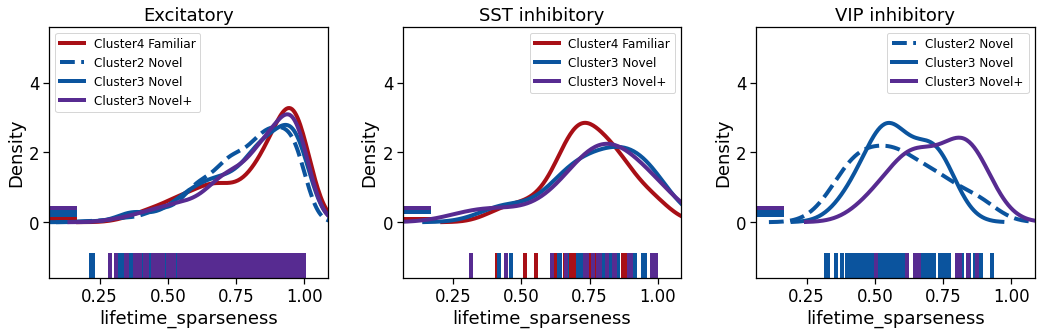

In [374]:
def plot_kde_rugplot(ax, data, y_shift, label, color, linestyle='-'):
    ax = sns.kdeplot(np.squeeze(data), color=color, linewidth=4, linestyle=linestyle, ax=ax)
    ax = sns.rugplot(np.squeeze(data), axis='x', y = y_shift, #y=np.ones_like(np.squeeze(data)) * y_shift, 
                     color=color, linewidth=4, height=0.1, ax=ax)
    return ax
def plot_ecdplot(ax, data, color, linestyle='-'):
    ax = sns.ecdfplot(np.squeeze(data), color=color, linewidth=4, linestyle=linestyle, ax=ax)


def prepare_data(cluster_id, exp_level, cre_line):
    tmp = cluster_df[(cluster_df.cluster_id == cluster_id) & (cluster_df.cre_line == cre_line)]
    cids = tmp.cell_specimen_id.values
    return df.loc[cids][[rm_f]][[(rm_f, exp_level)]].values


fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax = ax.ravel()

height = 0.1  # Adjust height for rugplots

for c, cre in enumerate(cre_lines):
    labels = []
    colors = gvt.project_colors()
    
    y_min, y_max = -1, 5
    x_min, x_max = 0.15, 1

    # Plotting clusters for different experience levels
    for cluster_id, exp_level, y_shift, linestyle in zip([3, 1, 2, 2], ['Familiar', 'Novel 1', 'Novel 1', 'Novel >1'], [0.1, 0.2, 0.3, 0.4], ['-', '--', '-', '-']):
        data = prepare_data(cluster_id, exp_level, cre)
        if len(data) > 1:
            ax[c] = plot_kde_rugplot(ax[c], data, y_shift, f'Cluster{cluster_id+1} {processing.get_experience_map(exp_level)}', colors[exp_level], linestyle=linestyle)
            labels.append(f'Cluster{cluster_id+1} {processing.get_experience_map(exp_level)}')
            
            # get limits
            y_min = min(y_min, np.min(data))
            y_max = max(y_max, np.max(data))
            
    
    # Set y limits
    ax[c].set_ylim([y_min - 0.1 * (y_max - y_min), y_max + 0.1 * (y_max - y_min)])
    ax[c].set_xlim([x_min - 0.1 * (x_max - x_min), x_max + 0.1 * (x_max - x_min)])
    ax[c].legend(labels, fontsize=12)
    ax[c].set_xlabel(rm_f)
    
    ax[c].set_title(processing.get_cre_line_map(cre))

plt.tight_layout()
plt.show()

In [391]:
rm_f = 'lifetime_sparseness'

'lifetime_sparseness'

313
611
377
377


C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\seaborn\distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\seaborn\distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\seaborn\distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\seaborn\distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureW

AttributeError: 'NoneType' object has no attribute 'legend'

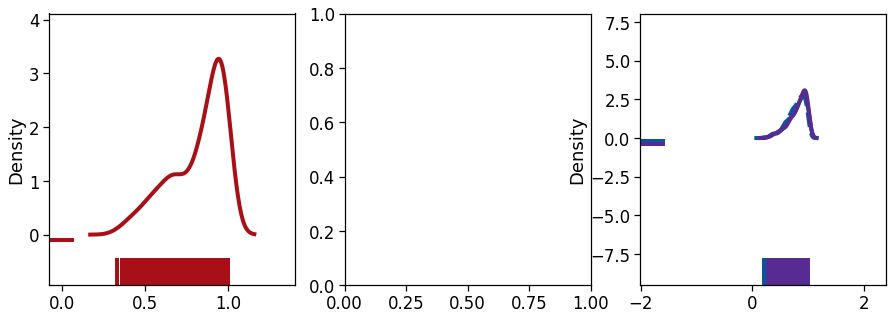

In [392]:
def prepare_data(cluster_id, exp_level, cre_line, rm_f):
    tmp = cluster_df[(cluster_df.cluster_id == cluster_id) & (cluster_df.cre_line == cre_line)]
    cids = tmp.cell_specimen_id.values
    return df.loc[cids][[rm_f]][[(rm_f, exp_level)]].values

def plot_kde_rugplot(ax, data, color, y_shift, linestyle='-'):
    ax = sns.kdeplot(np.squeeze(data), color=color, linewidth=4, linestyle=linestyle, ax=ax)
    ax = sns.rugplot(np.squeeze(data), axis='x', y = y_shift, #y=np.ones_like(np.squeeze(data)) * y_shift, 
                     color=color, linewidth=4, height=0.1, ax=ax)

def plot_cluster_rugplots(ax, cre_line, cluster_ids, exp_levels, rm_f, linestyles=None):
    labels = []
    colors = gvt.project_colors()
    y_shift_base = -0.1

    for cluster_id, exp_level, linestyle in zip(cluster_ids, exp_levels, linestyles):
        data = prepare_data(cluster_id, exp_level, cre_line, rm_f)
        print(len(data))
        if len(data) > 1:
            ax = plot_kde_rugplot(ax, data, colors[exp_level], y_shift_base, linestyle)
            labels.append(f'Cluster{cluster_id+1} {processing.get_experience_map(exp_level)}')
            y_shift_base -= 0.1  # Adjust the shift for the next level

    ax.legend(labels, fontsize=12)
    ax.set_xlabel(rm_f)
    ax.set_ylim([-1, ax.get_ylim()[1]])  # Adjust y-axis limit as needed
    return ax

# Example usage
cluster_ids_list = [3, 1, 2, 2]
exp_levels_list = ['Familiar', 'Novel 1', 'Novel 1', 'Novel >1']
linestyles = ['-', '--', '-', '-']
rm_f = 'lifetime_sparseness'
fig, ax = plt.subplots(1, len(cre_lines), figsize=(5 * len(cre_lines), 5))
ax =ax.ravel()
height = 0.1  # Adjust height for rugplots

for i, cre_line in enumerate(cre_lines):
    plot_cluster_rugplots(ax[i], cre_line, cluster_ids_list, exp_levels_list, rm_f, linestyles, )

plt.tight_layout()
plt.show()


C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\seaborn\distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\seaborn\distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\seaborn\distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\seaborn\distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureW

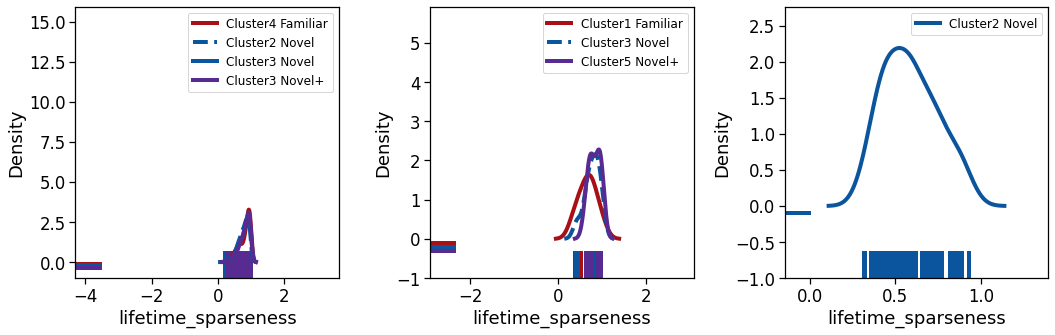

In [384]:

def plot_kde_rugplot(ax, data, color, y_shift, linestyle='-'):
    ax = sns.kdeplot(np.squeeze(data), color=color, linewidth=4, linestyle=linestyle, ax=ax)
    ax = sns.rugplot(np.squeeze(data), axis='x', y=y_shift, color=color, linewidth=4, height=0.1, ax=ax)
    return ax

def plot_cluster_rugplots(ax, cre_line, cluster_ids, exp_levels, linestyles=None):
    labels = []
    colors = gvt.project_colors()
    y_shift_base = -0.1

    for cluster_id, exp_level, linestyle in zip(cluster_ids, exp_levels, linestyles):
        data = prepare_data(cluster_id, exp_level, cre_line)
        if len(data) > 1:
            ax = plot_kde_rugplot(ax, data, colors[exp_level], y_shift_base, linestyle)
            labels.append(f'Cluster{cluster_id+1} {processing.get_experience_map(exp_level)}')
            y_shift_base -= 0.1  # Adjust the shift for the next level

    ax.legend(labels, fontsize=12)
    ax.set_xlabel(rm_f)
    ax.set_ylim([-1, ax.get_ylim()[1]])  # Adjust y-axis limit as needed
    return ax

# Example usage
cluster_ids_list = [[3, 1, 2, 2], [0, 2, 4], [1, 3]]
exp_levels_list = [['Familiar', 'Novel 1', 'Novel 1', 'Novel >1'], ['Familiar', 'Novel 1', 'Novel >1'], ['Novel 1', 'Familiar']]
linestyles = ['-', '--', '-', '-']

fig, ax = plt.subplots(1, len(cre_lines), figsize=(5 * len(cre_lines), 5))
height = 0.1  # Adjust height for rugplots

for i, (cre_line, cluster_ids, exp_levels) in enumerate(zip(cre_lines, cluster_ids_list, exp_levels_list)):
    plot_cluster_rugplots(ax[i], cre_line, cluster_ids, exp_levels, linestyles)

plt.tight_layout()
plt.show()

In [250]:

df = rm_unstacked_all
suffix='_all'
folder = 'distributions_all_images'

for index, rm_f in enumerate(rm_features):
    for cluster_id_1 in range(1,13): #5
        for cluster_id_2 in range(1,13): #9
            for exp_level_1 in experience_levels:
                for exp_level_2 in experience_levels:
                        
                    fig,ax = plt.subplots(1,3, figsize=(15,7), )#sharex=True)
                    ax=ax.ravel()
                    for c,cre in enumerate(cre_lines):
                        
                        # get data from first cluster
                        tmp = cluster_df[(cluster_df.cluster_id==cluster_id_1-1) & (cluster_df.cre_line==cre)]
                        cids = tmp.cell_specimen_id.values
                        try:
                            data = df.loc[cids][[rm_f]][[(rm_f,  exp_level_1)]]
                            data_array1=data.values

                        except:
                            data_array1 =[]
                            print('no cells')
                            
                        # get data from second cluster    
                        tmp = cluster_df[(cluster_df.cluster_id==cluster_id_2-1) & (cluster_df.cre_line==cre)]
                        cids = tmp.cell_specimen_id.values
                        try: 
                            data = df.loc[cids][[rm_f]][[(rm_f,  exp_level_2)]]
                            data_array2=data.values
                        except:
                            data_array2 = []
                            print('no cells')
                            
                        # change to one sample test if comparing cells within the same cluster
                        if cluster_id_1 == cluster_id_2:
                            test='W'
                        else:
                            test='MW'
                                     
                        # plot figure
                        if rm_f == 'mean_response':
                            
                            plot_boxplot(data_array1, data_array2, exp_level_1, exp_level_2, 
                                         ax = ax[c], patch_artist=True, widths = 0.5, test=test, suffix=suffix)
                        else:
                            plot_distribution(data_array1, data_array2, exp_level_1, exp_level_2, 
                                          ax = ax[c], bins=30, density=True, label=False, test=test, suffix=suffix)
                    if exp_level_2 == 'Novel >1':
                        exp_level_2 = 'Novel+'
                    if exp_level_1 == 'Novel >1':
                        exp_level_1 = 'Novel+'
                    plt.suptitle(f'cluster {cluster_id_1} and cluster {cluster_id_2}')
                    plt.tight_layout()
                    # figname
                    filename = f'{rm_f}_{cluster_id_1}_{cluster_id_2}_{exp_level_1}_{exp_level_2}.png'
                    figname = os.path.join(save_dir,folder , filename) 
                    fig.savefig(figname)
                    plt.close('all')


C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\scipy\stats\morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


no cells


C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
n